# Choosing a lens

## Plotly plot of the kmapper graph associated to the breast cancer dataset

In [4]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with conda or pip  and then try again.")
    sys.exit()

import numpy as np
import sklearn
from sklearn import ensemble
import kmapper as km
from kmapper.plotlyviz import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

In [65]:
# Data - the Wisconsin Breast Cancer Dataset
# https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
path = '/Users/shusasaki/Downloads/FIAS/GitHub/kepler-mapper/examples/breast-cancer/data.csv'
df = pd.read_csv(path)
feature_names = [c for c in df.columns if c not in ["id", "diagnosis"]]
df["diagnosis"] = df["diagnosis"].apply(lambda x: 1 if x == "M" else 0)
X = np.array(df[feature_names].fillna(0))
y = np.array(df["diagnosis"])

# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))


First we visualize the resulting graph via a   `color_function` that associates to lens data   their  x-coordinate distance to min, and  colormap these coordinates  to a given Plotly colorscale. Here we use the brewer colorscale with hex color codes.

In [66]:
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

In [67]:
color_values = lens [:,0] - lens[:,0].min()
my_colorscale = pl_brewer
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                 color_values,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)

# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]                         

Since the chosen colorscale leads  to a few light colors when it it used for histogram bars,
we set a black background color to make the bars visible:

In [68]:
bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

In [69]:
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


In [70]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [71]:
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In the following we illustrate how  we can duplicate FigureWidget(s) and update them. This is just a pretext to
illustrate how the kmapper graph figure can be manipulated for a more in-depth study or for 
publication.

Here we duplicate the initial FigureWidget, `fw_graph`,  and recolor its  graph nodes according to the proportion of malignant members. The two FigureWidgets are then restyled and plotted alonside each other for comparison.

In [72]:
breastc_dict = {0: 'benign', 1: 'malignant'}
tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips

new_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y[scomplex['nodes'][node['name']]]
    member_labels = [breastc_dict[id] for id in member_label_ids]
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    
    n_members = label_counts.sum()
    if label_type.shape[0] == 1:
        if label_type[0] == 'benign':
            new_color.append(0)
        else:
            new_color.append(1)
    else:        
        new_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
       
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) # append  how many benign/malign 
                                                                                 # members exist in each node

fwn_graph = go.FigureWidget(fw_graph) # copy the initial FigureWidget

with fwn_graph.batch_update(): # make updates for the new figure                                                                
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels
    
fw1 = go.FigureWidget(fwn_graph) # define a new figure from  the fwn_graph that will be colored by the new color function  
with fw1.batch_update():
    fw1.data[1].marker.color = new_color # update node colors
    fw1.data[0].line.color = 'rgb(125,125,125)' # update the graph edge color
    fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
    fw1.layout.annotations = None # remove the mapper_summary from the second plot
    fw1.data[1].marker.showscale = False # remove the colorbar
    fw1.layout.title = "Nodes are colored according to the proportion<br> of malignant members"

Plot  the dashboard consisting in the two figures:

In [73]:
HBox([fwn_graph, fw1])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

To save any of the FigureWidgets generated above uncomment the two lines  in the next cell, and replace `fw_graph` and the name of pdf file
adequately:

In [74]:
#import plotly.io as pio
#pio.write_image(fw_graph, 'breast-graph1.pdf') # or png, swg

## A note on the choice of lens

The reasoning behind the choice of lenses in the demonstration above is:

**For lens1:** Lenses that make biological sense; in other words, lenses that highlight special features in the data, that I know about. In the case of this particualr data, using an anomaly score (in this case calculated using the IsolationForest from sklearn) makes biological sense since cancer cells are anomalous.

**For lens2:** Lenses that disperse the data, as opposed to clustering many points together.

Below we demonstrate the same result can be obtained with a different choice for lens2:

In [101]:
# Create a 1-D lens with the First Principal Component from PCA
lens3 = mapper.fit_transform(X, projection=PCA(n_components=1))

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
isoForest_pca = np.c_[lens1, lens3]


Before we construct the simplicial complexes with these lenses, let us examine the effect the lenses have on the data:

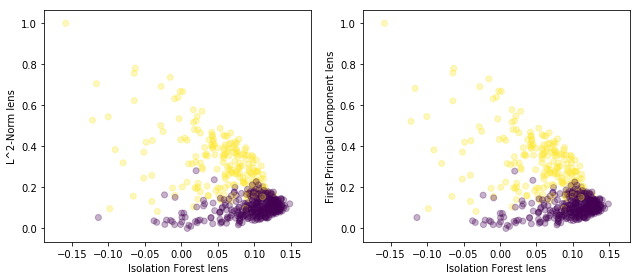

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(lens1,lens2,c=y.reshape(-1,1),alpha=0.3)
axs[0].set_xlabel('Isolation Forest lens')
axs[0].set_ylabel('L^2-Norm lens')

axs[1].scatter(lens1,lens3,c=y.reshape(-1,1),alpha=0.3)
axs[1].set_xlabel('Isolation Forest lens')
axs[1].set_ylabel('First Principal Component lens')

plt.tight_layout()

plt.show()

This shows that using the L^2-Norm and the first principal component as the second lens would probably generate very similar topological graphs. 

(Note that this also shows that the first principal component of the data **is** the L^2-Norm or very close to the L^2-Norm and that can be confirmed by inspecting the values in the arrays.)

In [109]:
# Define the simplicial complexes

# one lens
scomplex_isoForest = mapper.map(lens1,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# two lenses
scomplex_isoForest_pca = mapper.map(isoForest_pca,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

In [106]:
# visualise scomplex_isoForest
color_values = lens1[:,0] - lens1[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_isoForest, 
                                                                 color_values,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]                         

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [104]:
# visualise scomplex_isoForest_pca
color_values = isoForest_pca[:,0] - isoForest_pca[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_isoForest_pca, 
                                                                 color_values,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]                         

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

This shows that the anomaly score (biologically relevant) elucidates the global shape of the data, and the L^2-Norm (or first PC from principal component from PCA), which disperses the datapoints in one dimension, highlighs less granular (more detailed) local structures.

We can do a similar analysis using a different biologically-relevant lens:

In [136]:
# Create a 1-D lens with the values of the texture_mean feature of the dataset 
lens4 = mapper.fit_transform(X, projection=[1])

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
texture_l2norm = np.c_[lens4, lens2]


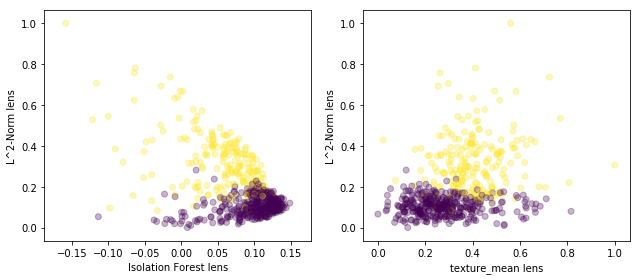

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(lens1,lens2,c=y.reshape(-1,1),alpha=0.3)
axs[0].set_xlabel('Isolation Forest lens')
axs[0].set_ylabel('L^2-Norm lens')

axs[1].scatter(lens4,lens2,c=y.reshape(-1,1),alpha=0.3)
axs[1].set_xlabel('texture_mean lens')
axs[1].set_ylabel('L^2-Norm lens')

plt.tight_layout()

plt.show()

In [138]:
# Define the simplicial complexes
# one lens
scomplex_texture = mapper.map(lens4,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# two lenses
scomplex_texture_l2norm = mapper.map(radius_l2norm,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

In [139]:
# visualise scomplex_radius
color_values = lens4[:,0] - lens4[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_texture, 
                                                                 color_values,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]                         

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [140]:
# visualise scomplex_radius_l2norm
color_values = texture_l2norm[:,0] - texture_l2norm[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_texture_l2norm, 
                                                                 color_values,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]                         

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…